# Inferencing MNIST ONNX Model using AI-Serving

In this tutorial, we will use the Open Neural Network eXchange (ONNX) format to show how to deploy a pre-trained Unet model using AI-Serving.

## Prerequisites to run the notebook

1). 准备Unet的ONNX模型，放在了`./model/unet.onnx`。   


2). Pull the latest docker image of AI-Serving with ONNX that leverages the CPU version of [ONNX Runtime](https://github.com/microsoft/onnxruntime). Please, refer to [Docker Containers for AI-Serving](https://github.com/autodeployai/ai-serving/tree/master/dockerfiles) about more docker images.

```bash
docker pull autodeployai/ai-serving

or

docker pull fusimeng/ai-serving:latest
```

3). Start a docker container of AI-Serving. The port `9090` is the port of HTTP endpoint while `9091` is for gRPC, you could see an error likes `Bind for 0.0.0.0:9090 failed: port is already allocated`, please use another new port instead of the first part as follows `-p $(NEW_PORT):9090` to run the command again, and remember the port is always needed in the URL of HTTP endpoint. 

```bash
docker run --rm -it -v $(PWD):/opt/ai-serving -p 9090:9090 -p 9091:9091 autodeployai/ai-serving
```

## Additional information about two python files
In the current directory, there are two python files `onnx_ml_pb2.py` and `ai_serving_pb2.py`, which are generated from compiling the [two proto files](https://github.com/autodeployai/ai-serving/tree/master/src/main/protobuf) using [protoc](https://developers.google.com/protocol-buffers/docs/pythontutorial), for example, the command as follows:

```bash
protoc -I=$SRC_DIR --python_out=. ai-serving.proto onnx-ml.proto
```

## Import dependent libraries
Import some dependent libraries that we are going to need to run the MNIST ONNX model.

In [1]:
from os import path
import numpy as np
import requests
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from pprint import pprint
import requests
from PIL import Image


import sys
sys.path.append("aiserving_lib")
import onnx_ml_pb2
import ai_serving_pb2

## Define the base HTTP URL
Change the port number `9090` to the appropriate port number if you had changed it during AI-Serving docker instantiation

In [2]:
port = 9090
base_url = 'http://localhost:' + str(port)

## Test the server availability
Use the specific endpoint `http://host:port/up` to test whether the server has been initialized and is ready to accept requests. The `OK` message indicates it's already available.

In [3]:
test_url = base_url + '/up'
response = requests.get(test_url)
print('The status of the server: ', response.text)

The status of the server:  OK


## Deploy the ONNX model into AI-Serving
First, we need to deploy the Unet ONNX model `model/unet.onnx` into AI-Serving, which can serve multiple models or multiple versions for a named model at once.

You must specify a correct content type for ONNX models when constructing an HTTP request to deploy an ONNX model, the candidates are:
 * application/octet-stream
 * application/vnd.google.protobuf
 * application/x-protobuf

In [4]:
# The specified servable name
model_name = 'unet'
deployment_url = base_url + '/v1/models/' + model_name

# The specified content type for the model:
headers = {'Content-Type': 'application/x-protobuf'}

model_path = path.join('model', 'unet.onnx')
with open(model_path, 'rb') as file:
    deployment_response = requests.put(deployment_url, headers=headers, data=file)

# The response is a JSON object contains the sepcified servable name and the model version deployed
deployment_response_info = deployment_response.json()
print('The depoyment response: ', deployment_response_info)

The depoyment response:  {'name': 'unet', 'version': 3}


## Retrieve metadata of the deployed model
The metadata will contain model inputs and outputs, which are needed when constructing an input request and consume an output response.

In [5]:
model_version = deployment_response_info['version']
metadata_url = base_url + '/v1/models/' + model_name + '/versions/' + str(model_version)
print(metadata_url)
metadata_response = requests.get(metadata_url)

print('The model metadata info:')
pprint(metadata_response.json())

http://localhost:9090/v1/models/unet/versions/3
The model metadata info:
{'createdAt': '2020-07-28T00:44:21',
 'id': 'ce826a1c-4752-46f3-a805-d1e8c3e067c2',
 'latestVersion': 3,
 'name': 'unet',
 'updateAt': '2020-07-28T01:16:17',
 'versions': [{'createdAt': '2020-07-28T01:16:17',
               'hash': '8642f636bb8c3567e150623c5407c929',
               'outputs': [{'name': 'output_0',
                            'shape': [1, 1, 1280, 1918],
                            'type': 'tensor(float)'}],
               'predictors': [{'name': 'input_0',
                               'shape': [1, 3, 1280, 1918],
                               'type': 'tensor(float)'}],
               'runtime': 'ONNX Runtime',
               'serialization': 'onnx',
               'size': 69129776,
               'type': 'ONNX',
               'version': 3}]}


## Load the input images
We will use the sample test data in `images`, there are 1 test cases that include both input and output data.

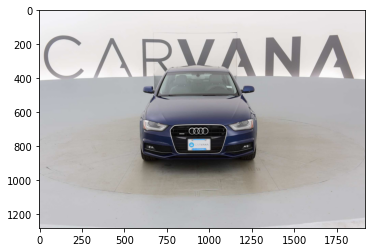

In [6]:
# Load the raw image
img = Image.open("images/input.jpg")
# Let us see what the input image looks like
plt.imshow(img)

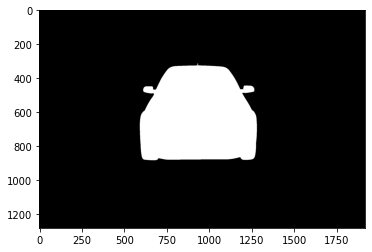

In [7]:
# Load the raw image
img_mask = Image.open("images/mask.gif")
# Let us see what the input image looks like
plt.imshow(img_mask)


## Pre-process the input image
Having loaded and resized the raw image to fit the model's requirements, we are further going to pre-process the image to take it to a state that the model has seen before as part of the "training" phase of the model.

In [8]:
# Preprocess and normalize the image

img_data = np.array(img)
img_data = np.transpose(img_data, [2, 0, 1])
img_data = np.expand_dims(img_data, 0)
# mean_vec = np.array([0.485, 0.456, 0.406])
# stddev_vec = np.array([0.229, 0.224, 0.225])
# norm_img_data = np.zeros(img_data.shape).astype('float32')
# for i in range(img_data.shape[1]):
#     norm_img_data[:,i,:,:] = (img_data[:,i,:,:]/255 - mean_vec[i]) / stddev_vec[i]
norm_img_data = img_data.astype('float32')
print(norm_img_data.shape)
print(norm_img_data)

(1, 3, 1280, 1918)
[[[[244. 244. 244. ... 234. 234. 234.]
   [244. 244. 244. ... 234. 234. 234.]
   [244. 244. 244. ... 234. 234. 234.]
   ...
   [210. 210. 210. ... 226. 226. 226.]
   [210. 210. 210. ... 228. 228. 228.]
   [210. 210. 210. ... 230. 230. 230.]]

  [[243. 243. 243. ... 230. 230. 230.]
   [243. 243. 243. ... 230. 230. 230.]
   [243. 243. 243. ... 230. 230. 230.]
   ...
   [209. 209. 209. ... 226. 226. 226.]
   [209. 209. 209. ... 228. 228. 228.]
   [209. 209. 209. ... 230. 230. 230.]]

  [[248. 248. 248. ... 231. 231. 231.]
   [248. 248. 248. ... 231. 231. 231.]
   [248. 248. 248. ... 231. 231. 231.]
   ...
   [214. 214. 214. ... 226. 226. 226.]
   [214. 214. 214. ... 228. 228. 228.]
   [214. 214. 214. ... 230. 230. 230.]]]]


In [9]:
# Create request message to be sent to the ORT server

input_tensor = onnx_ml_pb2.TensorProto()
input_tensor.dims.extend(norm_img_data.shape)
input_tensor.data_type = 1
input_tensor.raw_data = norm_img_data.tobytes()
print("input_tensor type:", type(input_tensor))
input_tensor_array = np.frombuffer(input_tensor.raw_data, dtype=np.float32).astype('float32')
print("input_tensor_array type:", type(input_tensor_array))

input_tensor type: <class 'onnx_ml_pb2.TensorProto'>
input_tensor_array type: <class 'numpy.ndarray'>


## HTTP request formats for the AI-Serving
The request for AI-Serving could have two formats: JSON and binary, the HTTP header Content-Type tells the server which format to handle and thus it is required for all requests. The binary payload has better latency, especially for the big tensor value for ONNX models, while the JSON format is easy for human readability.

- Content-Type: application/octet-stream, application/vnd.google.protobuf or application/x-protobuf. The request body must be the protobuf message PredictRequest, besides of those common scalar values, it can use the standard TensorProto value directly.


- Content-Type: application/json. The request body must be a JSON object formatted as described [here](https://github.com/autodeployai/ai-serving#4-predict-api).

## Construct binary requests for the AI-Serving
We will create both instances of PredictRequest, one is using the `Records` format that has one case, the other is using the `Split` format that contains two cases.

In [10]:
from ai_serving_pb2 import RecordSpec, Record, PredictRequest, ListValue, Value

# Create an instance of RecordSpec using `records` that contains only the first tensor.
request_message_records = PredictRequest(X=RecordSpec(
    records=[Record(fields={'input_0': Value(tensor_value=input_tensor)})]
))

# Create an instance of RecordSpec using `split` that contains the last two tensors.
request_message_split = PredictRequest(X=RecordSpec(
    columns = ['input_0'],
    data = [
#         ListValue(values=[Value(tensor_value=input_tensors[1])]),
        ListValue(values=[Value(tensor_value=input_tensor)])
    ]
))

## Make the HTTP requests with binary data to the AI-Serving
Make predictions using the AI-Serving, the content type of requests with binary data must be one of those three candidates above.

In [11]:
headers = {'Content-Type': 'application/x-protobuf'}

# When version is omitted, the latest version is used.
prediction_url = base_url + '/v1/models/' + model_name

# Make prediction for the `records` request message.
prediction_response_records = requests.post(prediction_url, 
                                           headers=headers, 
                                           data=request_message_records.SerializeToString())

# Make prediciton for the `split` request message.
prediction_response_split = requests.post(prediction_url, 
                                           headers=headers, 
                                           data=request_message_split.SerializeToString())

## Consume the HTTP response with binary data from the AI-serving
Having received the results from the server, we are going to parse the "serialized" message that we just received for us to make sense of the results. And compare the actual results to the desired ones. 

**NOTE: The data format of the output response is always the same as the input request.**

In [12]:
print(prediction_response_records)
print(type(prediction_response_records))
# print(prediction_response_records.content)

<Response [200]>
<class 'requests.models.Response'>


In [13]:
# Parse the response message from the `recrods` request.
response_message = ai_serving_pb2.PredictResponse()
response_message.ParseFromString(prediction_response_records.content)

9820210

In [14]:
print(type(response_message))

<class 'ai_serving_pb2.PredictResponse'>


In [15]:
print(type(response_message.result))
print(type(response_message.result.records))

<class 'ai_serving_pb2.RecordSpec'>
<class 'google.protobuf.pyext._message.RepeatedCompositeContainer'>


In [16]:
output_tensor = response_message.result.records[0].fields['output_0'].tensor_value
print('Actual output shape of test data set : ', output_tensor.dims)

# Print the actual result for the tensor
actual_output_tensor_array = np.asarray(output_tensor.float_data, dtype=np.dtype('float32'))
print(type(actual_output_tensor_array))
print(actual_output_tensor_array.shape)
print(actual_output_tensor_array.dtype)

Actual output shape of test data set :  [1, 1, 1280, 1918]
<class 'numpy.ndarray'>
(2455040,)
float32


In [17]:
actual_output_tensor_array = actual_output_tensor_array.reshape((1, 1, 1280, 1918))
print(type(actual_output_tensor_array))
print(actual_output_tensor_array.shape)
print(actual_output_tensor_array.dtype)

<class 'numpy.ndarray'>
(1, 1, 1280, 1918)
float32


In [18]:
actual_output_tensor_array = np.array(actual_output_tensor_array[0][0]) 
print(type(actual_output_tensor_array))
print(actual_output_tensor_array.shape)
print(actual_output_tensor_array)

<class 'numpy.ndarray'>
(1280, 1918)
[[163.73814   281.78525   363.4546    ... 398.7231    371.14572
  239.31122  ]
 [169.08064   278.55783   359.2201    ... 378.2388    337.14072
  213.14668  ]
 [212.47649   349.2157    445.04913   ... 462.39453   409.84058
  259.26233  ]
 ...
 [118.94283   194.1717    241.48724   ... 275.90405   247.00745
  162.9558   ]
 [ 47.61417    78.42394   100.23748   ...  92.1107     76.386986
   54.487843 ]
 [ 31.208736   51.050266   60.890476  ...  43.316513   18.121248
    2.0475283]]


In [19]:
# res= Image.open("1.png")
# mat = np.array(src)
res = actual_output_tensor_array.astype(np.uint8)
# print(res>255)
res = Image.fromarray(res, 'P')
# dst.save('new.png')
print(type(res))

<class 'PIL.Image.Image'>


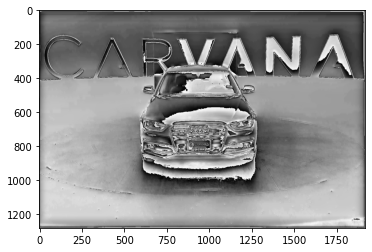

In [20]:
plt.imshow(res)

In [21]:
# Parse the response message from the `split` requesgt.
response_message = ai_serving_pb2.PredictResponse()
response_message.ParseFromString(prediction_response_split.content)
print(type(response_message))
print(type(response_message.result))
print(type(response_message.result.records))


<class 'ai_serving_pb2.PredictResponse'>
<class 'ai_serving_pb2.RecordSpec'>
<class 'google.protobuf.pyext._message.RepeatedCompositeContainer'>


In [24]:
print('Actual output shape of test data set : ', response_message.result.columns)


Actual output shape of test data set :  ['output_0']


<class 'numpy.ndarray'>
(2455040,)
float32
<class 'numpy.ndarray'>
(1, 1, 1280, 1918)
float32
<class 'numpy.ndarray'>
(1280, 1918)
[[163.73814   281.78525   363.4546    ... 398.7231    371.14572
  239.31122  ]
 [169.08064   278.55783   359.2201    ... 378.2388    337.14072
  213.14668  ]
 [212.47649   349.2157    445.04913   ... 462.39453   409.84058
  259.26233  ]
 ...
 [118.94283   194.1717    241.48724   ... 275.90405   247.00745
  162.9558   ]
 [ 47.61417    78.42394   100.23748   ...  92.1107     76.386986
   54.487843 ]
 [ 31.208736   51.050266   60.890476  ...  43.316513   18.121248
    2.0475283]]
<class 'PIL.Image.Image'>


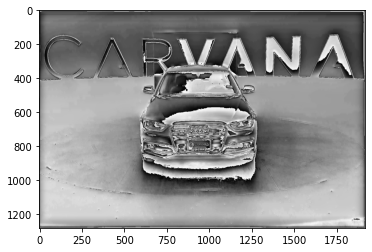

In [25]:
output_tensor = response_message.result.data[0].values[0].tensor_value
# Print the actual result for the tensor
actual_output_tensor_array = np.asarray(output_tensor.float_data, dtype=np.dtype('float32'))
print(type(actual_output_tensor_array))
print(actual_output_tensor_array.shape)
print(actual_output_tensor_array.dtype)
actual_output_tensor_array = actual_output_tensor_array.reshape((1, 1, 1280, 1918))
print(type(actual_output_tensor_array))
print(actual_output_tensor_array.shape)
print(actual_output_tensor_array.dtype)
actual_output_tensor_array = np.array(actual_output_tensor_array[0][0]) 
print(type(actual_output_tensor_array))
print(actual_output_tensor_array.shape)
print(actual_output_tensor_array)
# res= Image.open("1.png")
# mat = np.array(src)
res = actual_output_tensor_array.astype(np.uint8)
# print(res>255)
res = Image.fromarray(res, 'P')
# dst.save('new.png')
print(type(res))
plt.imshow(res)

## Construct JSON requests for the AI-Serving
Create both JSON objects, one is using the `Records` format that has one case, the other is using `Split` that contains two cases.

In [26]:
# Create a JSON object with records that contains only the first tensor.
request_json_recoreds = {
    'X': [{
        'input_0': input_tensor_array.tolist()
    }]
}

# Create a JSON object with columns and data that contains the last two tensors.
request_json_split = {
    'X': {
        'columns': ['input_0'],
        'data': [[input_tensor_array.tolist()]]
    }
}

## Make the HTTP requests with JSON data to the AI-Serving
Make predictions using the AI-Serving, the content type of requests with JSON data must be `application/json`.

In [27]:
# When version is omitted, the latest version is used.
prediction_url = base_url + '/v1/models/' + model_name

# The Content-Type: application/json is specified implicitly when using json instead of data
prediction_json_response_records = requests.post(prediction_url, json=request_json_recoreds)
prediction_json_response_split = requests.post(prediction_url, json=request_json_split)

## Consume the HTTP response with JSON data from the AI-serving
Having received the results from the server, we are going to parse the JSON text that we just received for us to make sense of the results. And compare the actual results to the desired ones.

**NOTE: The data format of the output response is always the same as the input request.**

In [37]:
# Parse the json response from the `recrods` request.
response_json = prediction_json_response_records.json()
print('The json response from the `records` request:', type(response_json))
# for key in response_json.keys:
#     print(key)
# pprint(response_json)

The json response from the `records` request: <class 'dict'>


In [39]:
output_list = response_json['result'][0]['output_0']
actual_output_tensor_array = np.asarray(output_list, dtype=np.dtype('float32'))

<class 'numpy.ndarray'>
(1, 1, 1280, 1918)
float32
<class 'numpy.ndarray'>
(1, 1, 1280, 1918)
float32
<class 'numpy.ndarray'>
(1280, 1918)
[[163.73814   281.78525   363.4546    ... 398.7231    371.14572
  239.31122  ]
 [169.08064   278.55783   359.2201    ... 378.2388    337.14072
  213.14668  ]
 [212.47649   349.2157    445.04913   ... 462.39453   409.84058
  259.26233  ]
 ...
 [118.94283   194.1717    241.48724   ... 275.90405   247.00745
  162.9558   ]
 [ 47.61417    78.42394   100.23748   ...  92.1107     76.386986
   54.487843 ]
 [ 31.208736   51.050266   60.890476  ...  43.316513   18.121248
    2.0475283]]
<class 'PIL.Image.Image'>


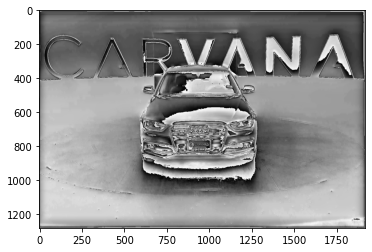

In [40]:
# Print the actual result for the tensor
print(type(actual_output_tensor_array))
print(actual_output_tensor_array.shape)
print(actual_output_tensor_array.dtype)
actual_output_tensor_array = actual_output_tensor_array.reshape((1, 1, 1280, 1918))
print(type(actual_output_tensor_array))
print(actual_output_tensor_array.shape)
print(actual_output_tensor_array.dtype)
actual_output_tensor_array = np.array(actual_output_tensor_array[0][0]) 
print(type(actual_output_tensor_array))
print(actual_output_tensor_array.shape)
print(actual_output_tensor_array)
# res= Image.open("1.png")
# mat = np.array(src)
res = actual_output_tensor_array.astype(np.uint8)
# print(res>255)
res = Image.fromarray(res, 'P')
# dst.save('new.png')
print(type(res))
plt.imshow(res)

In [41]:
response_json = prediction_json_response_split.json()
output_list = response_json['result']['data'][0] #response_json['result'][0]['output_0']
actual_output_tensor_array = np.asarray(output_list, dtype=np.dtype('float32'))

<class 'numpy.ndarray'>
(1, 1, 1, 1280, 1918)
float32
<class 'numpy.ndarray'>
(1, 1, 1280, 1918)
float32
<class 'numpy.ndarray'>
(1280, 1918)
[[163.73814   281.78525   363.4546    ... 398.7231    371.14572
  239.31122  ]
 [169.08064   278.55783   359.2201    ... 378.2388    337.14072
  213.14668  ]
 [212.47649   349.2157    445.04913   ... 462.39453   409.84058
  259.26233  ]
 ...
 [118.94283   194.1717    241.48724   ... 275.90405   247.00745
  162.9558   ]
 [ 47.61417    78.42394   100.23748   ...  92.1107     76.386986
   54.487843 ]
 [ 31.208736   51.050266   60.890476  ...  43.316513   18.121248
    2.0475283]]
<class 'PIL.Image.Image'>


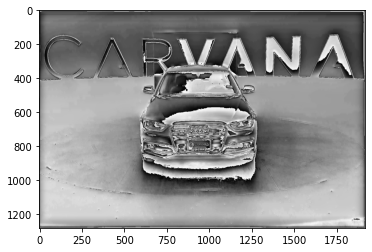

In [42]:
# Print the actual result for the tensor
print(type(actual_output_tensor_array))
print(actual_output_tensor_array.shape)
print(actual_output_tensor_array.dtype)
actual_output_tensor_array = actual_output_tensor_array.reshape((1, 1, 1280, 1918))
print(type(actual_output_tensor_array))
print(actual_output_tensor_array.shape)
print(actual_output_tensor_array.dtype)
actual_output_tensor_array = np.array(actual_output_tensor_array[0][0]) 
print(type(actual_output_tensor_array))
print(actual_output_tensor_array.shape)
print(actual_output_tensor_array)
# res= Image.open("1.png")
# mat = np.array(src)
res = actual_output_tensor_array.astype(np.uint8)
# print(res>255)
res = Image.fromarray(res, 'P')
# dst.save('new.png')
print(type(res))
plt.imshow(res)